# Reasoning-Informed Fine-tuning 

In [1]:
!pip install transformers[torch] datasets evaluate scikit-learn psutil accelerate sentencepiece --quiet

In [2]:
import os
import gc
import json
import random
import time
import psutil
import torch
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from datasets import Dataset, load_dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer, DataCollatorWithPadding
from sklearn.metrics import accuracy_score, f1_score, recall_score, confusion_matrix


MODELS_TO_TRAIN = {
    'Ukr-RoBERTa': 'youscan/ukr-roberta-base',
    'mDeBERTa-v3': 'microsoft/mdeberta-v3-base'
}

RATIONALES_FILE = "datasets/rationales_train.jsonl"
TRAIN_FILE = "datasets/train.jsonl"
TEST_FILE = "datasets/test_mixed_safe.jsonl"
HARD_TEST_FILE = "datasets/hard_test.jsonl"

LABEL_MAP = {'safe': 0, 'propaganda': 1, 'harmful': 2}
ID2LABEL = {0: 'safe', 1: 'propaganda', 2: 'harmful'}

In [3]:
# NLI Dataset (Text + Rationale -> 0/1)
def create_nli_dataset(input_file):
    with open(input_file, 'r', encoding='utf-8') as f:
        raw_records = [json.loads(line) for line in f]
    
    rationales_by_tag = {'safe': [], 'propaganda': [], 'harmful': []}
    for r in raw_records:
        tag = r.get('tag') or r.get('label')
        if tag in rationales_by_tag and 'rationale' in r:
            rationales_by_tag[tag].append(r['rationale'])
            
    nli_samples = []
    for rec in raw_records:
        text = rec.get('prompt') or rec.get('text')
        true_tag = rec.get('tag') or rec.get('label')
        true_rationale = rec.get('rationale', '')
        
        if not true_rationale or not text or not true_tag: continue
        
        # Positive (Entailment)
        nli_samples.append({'text_a': text, 'text_b': true_rationale, 'label': 1})
        
        # Negative (Contradiction)
        other_tags = [l for l in ['safe', 'propaganda', 'harmful'] if l != true_tag]
        fake_tag = random.choice(other_tags)
        if rationales_by_tag[fake_tag]:
            fake_rationale = random.choice(rationales_by_tag[fake_tag])
            nli_samples.append({'text_a': text, 'text_b': fake_rationale, 'label': 0})
            
    return Dataset.from_list(nli_samples)


print("Generating NLI Dataset...")
nli_dataset = create_nli_dataset(RATIONALES_FILE)
nli_dataset = nli_dataset.train_test_split(test_size=0.1)
print(f"NLI Train: {len(nli_dataset['train'])}, Val: {len(nli_dataset['test'])}")

Generating NLI Dataset...
NLI Train: 3600, Val: 400


In [4]:
def compute_metrics_cls(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    acc = accuracy_score(labels, predictions)
    f1 = f1_score(labels, predictions, average='macro', zero_division=0)
    return {'accuracy': acc, 'f1_macro': f1}


for model_name, base_model_id in MODELS_TO_TRAIN.items():
    print(f"\n{'='*40}\nPROCESSING MODEL: {model_name}\n{'='*40}")
    
    OUTPUT_NLI = f"./results_reasoning_nli_{model_name}"
    OUTPUT_FINAL = f"./results_reasoning_cls_{model_name}"
    
    print("--- Stage 1: Reasoning Pre-training (NLI) ---")
    
    tokenizer = AutoTokenizer.from_pretrained(base_model_id)
    if tokenizer.pad_token is None:
        tokenizer.pad_token = tokenizer.eos_token
        
    def preprocess_nli(examples):
        return tokenizer(examples['text_a'], examples['text_b'], truncation=True, padding=False, max_length=512)

    encoded_nli = nli_dataset.map(preprocess_nli, batched=True)
    data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

    model_nli = AutoModelForSequenceClassification.from_pretrained(base_model_id, num_labels=2)
    
    trainer_nli = Trainer(
        model=model_nli,
        args=TrainingArguments(
            output_dir=OUTPUT_NLI,
            learning_rate=2e-6,
            per_device_train_batch_size=16,
            per_device_eval_batch_size=16,
            num_train_epochs=10,
            weight_decay=0.01,
            eval_strategy="epoch",
            save_strategy="epoch",
            save_total_limit=1,
            load_best_model_at_end=True,
            report_to="none",
            fp16=torch.cuda.is_available()
        ),
        train_dataset=encoded_nli['train'],
        eval_dataset=encoded_nli['test'],
        tokenizer=tokenizer,
        data_collator=data_collator,
    )
    trainer_nli.train()
    trainer_nli.save_model(OUTPUT_NLI)
    
    del model_nli, trainer_nli
    torch.cuda.empty_cache()
    gc.collect()
    
    print("--- Stage 2: Transfer to Classification ---")
    
    model_cls = AutoModelForSequenceClassification.from_pretrained(
        OUTPUT_NLI, 
        num_labels=3, 
        id2label=ID2LABEL, 
        label2id=LABEL_MAP,
        ignore_mismatched_sizes=True
    )
    
    dataset_cls = load_dataset('json', data_files={'train': TRAIN_FILE, 'test': TEST_FILE})
    def preprocess_cls(examples):
        return tokenizer(examples['prompt'], truncation=True, padding=False, max_length=512)

    encoded_cls = dataset_cls.map(preprocess_cls, batched=True)
    encoded_cls['train'] = encoded_cls['train'].map(lambda x: {'label': LABEL_MAP[x['tag']]})
    encoded_cls['test'] = encoded_cls['test'].map(lambda x: {'label': LABEL_MAP[x['tag']]})

    trainer_cls = Trainer(
        model=model_cls,
        args=TrainingArguments(
            output_dir=OUTPUT_FINAL,
            learning_rate=1e-6,
            per_device_train_batch_size=16,
            per_device_eval_batch_size=16,
            num_train_epochs=10,
            weight_decay=0.01,
            eval_strategy="epoch",
            save_strategy="epoch",
            save_total_limit=1,
            load_best_model_at_end=True,
            report_to="none",
            fp16=torch.cuda.is_available()
        ),
        train_dataset=encoded_cls['train'],
        eval_dataset=encoded_cls['test'],
        tokenizer=tokenizer,
        data_collator=data_collator,
        compute_metrics=compute_metrics_cls
    )
    trainer_cls.train()
    trainer_cls.save_model(OUTPUT_FINAL)
    
    del model_cls, trainer_cls
    torch.cuda.empty_cache()
    gc.collect()

print("\nAll models trained successfully!")


PROCESSING MODEL: Ukr-RoBERTa
--- Stage 1: Reasoning Pre-training (NLI) ---


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:104: UserWarning: 
Error while fetching `HF_TOKEN` secret value from your vault: 'Requesting secret HF_TOKEN timed out. Secrets can only be fetched when running from the Colab UI.'.
You are not authenticated with the Hugging Face Hub in this notebook.
If the error persists, please let us know by opening an issue on GitHub (https://github.com/huggingface/huggingface_hub/issues/new).
  warnings.warn(


Map:   0%|          | 0/3600 [00:00<?, ? examples/s]

Map:   0%|          | 0/400 [00:00<?, ? examples/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at youscan/ukr-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-2813354220.py:31: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer_nli = Trainer(


Epoch,Training Loss,Validation Loss
1,No log,0.608952
2,No log,0.503559
3,0.589800,0.380888
4,0.589800,0.311163
5,0.368600,0.277693
6,0.368600,0.230310
7,0.231500,0.201884
8,0.231500,0.195469
9,0.168300,0.190827
10,0.168300,0.190394


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at ./results_reasoning_nli_Ukr-RoBERTa and are newly initialized because the shapes did not match:
- classifier.out_proj.bias: found shape torch.Size([2]) in the checkpoint and torch.Size([3]) in the model instantiated
- classifier.out_proj.weight: found shape torch.Size([2, 768]) in the checkpoint and torch.Size([3, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


--- Stage 2: Transfer to Classification ---


Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/600 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/600 [00:00<?, ? examples/s]

/tmp/ipython-input-2813354220.py:80: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer_cls = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro
1,No log,0.430235,0.923333,0.922625
2,No log,0.255437,0.925000,0.924605
3,No log,0.224230,0.925000,0.924652
4,0.290400,0.223705,0.928333,0.928013
5,0.290400,0.287618,0.890000,0.888405
6,0.290400,0.312129,0.890000,0.888405
7,0.290400,0.290386,0.895000,0.893682
8,0.053900,0.308839,0.895000,0.893583
9,0.053900,0.318156,0.895000,0.893583
10,0.053900,0.310619,0.895000,0.893583



PROCESSING MODEL: mDeBERTa-v3
--- Stage 1: Reasoning Pre-training (NLI) ---


/usr/local/lib/python3.12/dist-packages/transformers/convert_slow_tokenizer.py:566: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


Map:   0%|          | 0/3600 [00:00<?, ? examples/s]

Map:   0%|          | 0/400 [00:00<?, ? examples/s]

Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/mdeberta-v3-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-2813354220.py:31: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer_nli = Trainer(
The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'eos_token_id': 2, 'bos_token_id': 1}.


Epoch,Training Loss,Validation Loss
1,No log,0.607860
2,No log,0.389748
3,0.565400,0.172933
4,0.565400,0.129860
5,0.181800,0.117545
6,0.181800,0.112914
7,0.101300,0.116154
8,0.101300,0.124427
9,0.077100,0.128358
10,0.077100,0.124545


Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at ./results_reasoning_nli_mDeBERTa-v3 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([2]) in the checkpoint and torch.Size([3]) in the model instantiated
- classifier.weight: found shape torch.Size([2, 768]) in the checkpoint and torch.Size([3, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


--- Stage 2: Transfer to Classification ---


Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/600 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/600 [00:00<?, ? examples/s]

/tmp/ipython-input-2813354220.py:80: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer_cls = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro
1,No log,0.799111,0.855000,0.850287
2,No log,0.521252,0.930000,0.929539
3,No log,0.368518,0.945000,0.944866
4,0.554300,0.284000,0.946667,0.946380
5,0.554300,0.243102,0.946667,0.946552
6,0.554300,0.217972,0.946667,0.946481
7,0.554300,0.200853,0.946667,0.946533
8,0.178700,0.195617,0.950000,0.949985
9,0.178700,0.193217,0.948333,0.948257
10,0.178700,0.191751,0.955000,0.954999



All models trained successfully!


In [5]:
def visualize_benchmark_results(metrics_df, preds_df, dataset_name="Mixed Test", title_prefix=""):
    print(f"\n{'='*40}\nBENCHMARK RESULTS: {dataset_name}\n{'='*40}")
    
    acc_cols = [c for c in metrics_df.columns if c in ['Model', 'Accuracy', 'F1 (Macro)', 'Recall (Safe)', 'Recall (Propaganda)', 'Recall (Harmful)']]
    res_cols = [c for c in metrics_df.columns if c in ['Model', 'Avg Latency (ms)', 'Peak VRAM (MB)', 'RAM Usage (MB)', 'CPU Usage (%)']]
    
    print("\n=== Accuracy Metrics ===")
    display(metrics_df[acc_cols].style.background_gradient(cmap='Greens', subset=[c for c in acc_cols if c != 'Model']).format(precision=4))
    
    if len(res_cols) > 1:
        print("\n=== Resource Efficiency Metrics ===")
        display(metrics_df[res_cols].style.background_gradient(cmap='Reds', subset=[c for c in res_cols if c != 'Model']).format(precision=0))
    
    labels = ['safe', 'propaganda', 'harmful']
    model_cols = [c for c in preds_df.columns if '_pred' in c]
    models = [c.replace('_pred','') for c in model_cols]
    n_models = len(models)
    if n_models == 0: return

    n_cols = 2
    n_rows = (n_models + n_cols - 1) // n_cols 
    color_map = 'Reds' if 'HARD' in dataset_name.upper() else 'Blues'
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 6 * n_rows))
    if n_models > 1: axes = axes.flatten()
    else: axes = [axes]
    
    for i, model in enumerate(models):
        y_true = preds_df['true_label']
        y_pred = preds_df[f'{model}_pred']
        cm = confusion_matrix(y_true, y_pred, labels=labels)
        sns.heatmap(cm, annot=True, fmt='d', xticklabels=labels, yticklabels=labels, ax=axes[i], cmap=color_map)
        
        full_title = f"[{title_prefix}] {model} | {dataset_name}" if title_prefix else f"{model} | {dataset_name}"
        axes[i].set_title(full_title, fontsize=12, fontweight='bold')
        axes[i].set_xlabel('Predicted')
        axes[i].set_ylabel('Actual')

    for i in range(n_models, len(axes)): fig.delaxes(axes[i])
    plt.tight_layout()
    plt.show()


def run_benchmark_on_dataset(dataset_path, dataset_name):
    print(f"Loading dataset: {dataset_path}...")
    df_raw = pd.read_json(dataset_path, lines=True)
    
    results_summary = []
    detailed_preds = pd.DataFrame({'true_label': df_raw['tag']})
    
    device = "cuda" if torch.cuda.is_available() else "cpu"

    for model_name, _ in MODELS_TO_TRAIN.items():
        model_path = f"./results_reasoning_cls_{model_name}"
        print(f"Evaluating {model_name} (Reasoning-tuned)...")
        
        if torch.cuda.is_available():
            torch.cuda.empty_cache()
            torch.cuda.reset_peak_memory_stats()
        gc.collect()
        psutil.cpu_percent(interval=None)

        try:
            model = AutoModelForSequenceClassification.from_pretrained(model_path).to(device)
            tokenizer = AutoTokenizer.from_pretrained(model_path)
        except Exception as e:
            print(f"Error loading {model_name}: {e}")
            continue
            
        latencies = []
        preds = []
        
        model.eval()
        
        for _, row in df_raw.iterrows():
            text = row['prompt']
            start = time.time()
            inputs = tokenizer(text, return_tensors="pt", truncation=True, max_length=512).to(device)
            with torch.no_grad():
                outputs = model(**inputs)
                pred_id = torch.argmax(outputs.logits, dim=-1).item()
            latencies.append((time.time() - start) * 1000)
            preds.append(ID2LABEL[pred_id])
            
        detailed_preds[f'{model_name}_pred'] = preds
        valid_labels = ['safe', 'propaganda', 'harmful']
        
        acc = accuracy_score(detailed_preds['true_label'], preds)
        f1 = f1_score(detailed_preds['true_label'], preds, average='macro', zero_division=0)
        recalls = recall_score(detailed_preds['true_label'], preds, labels=valid_labels, average=None, zero_division=0)
        
        peak_vram = torch.cuda.max_memory_allocated() / 1024 / 1024 if torch.cuda.is_available() else 0
        ram_usage = psutil.Process(os.getpid()).memory_info().rss / 1024 / 1024
        cpu_usage = psutil.cpu_percent(interval=None)
        
        results_summary.append({
            'Model': f"Reasoning-{model_name}",
            'Accuracy': acc,
            'F1 (Macro)': f1,
            'Recall (Safe)': recalls[0],
            'Recall (Propaganda)': recalls[1],
            'Recall (Harmful)': recalls[2],
            'Avg Latency (ms)': np.mean(latencies),
            'Peak VRAM (MB)': peak_vram,
            'RAM Usage (MB)': ram_usage,
            'CPU Usage (%)': cpu_usage
        })
        
        del model, tokenizer
        
    return pd.DataFrame(results_summary), detailed_preds


Loading dataset: datasets/test_mixed_safe.jsonl...
Evaluating Ukr-RoBERTa (Reasoning-tuned)...
Evaluating mDeBERTa-v3 (Reasoning-tuned)...


The tokenizer you are loading from './results_reasoning_cls_mDeBERTa-v3' with an incorrect regex pattern: https://huggingface.co/mistralai/Mistral-Small-3.1-24B-Instruct-2503/discussions/84#69121093e8b480e709447d5e. This will lead to incorrect tokenization. You should set the `fix_mistral_regex=True` flag when loading this tokenizer to fix this issue.



📊 BENCHMARK RESULTS: SIMPLE Test

=== 🎯 Accuracy Metrics ===


,Model,Accuracy,F1 (Macro),Recall (Safe),Recall (Propaganda),Recall (Harmful)
0,Reasoning-Ukr-RoBERTa,0.9283,0.9280,0.8550,1.0000,0.9300
1,Reasoning-mDeBERTa-v3,0.9500,0.9500,0.9400,0.9950,0.9150



=== ⚡ Resource Efficiency Metrics ===


,Model,Avg Latency (ms),Peak VRAM (MB),RAM Usage (MB),CPU Usage (%)
0,Reasoning-Ukr-RoBERTa,9,510,2958,11
1,Reasoning-mDeBERTa-v3,23,1115,3132,10


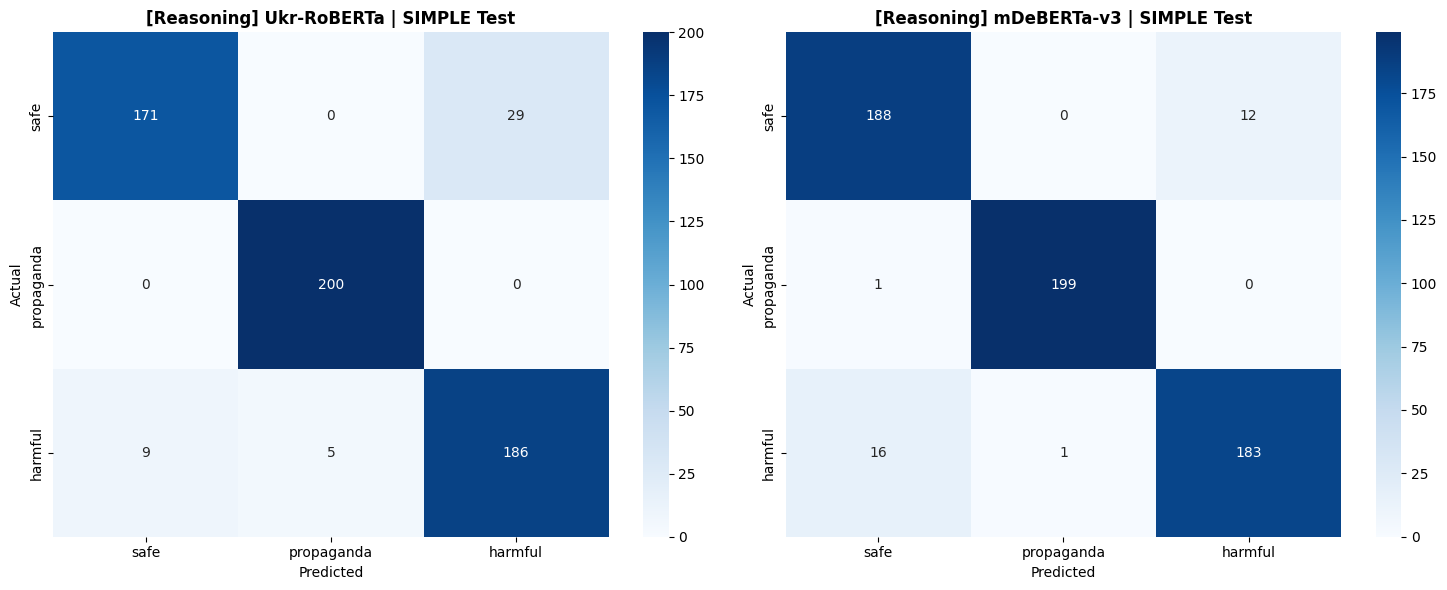

Loading dataset: datasets/hard_test.jsonl...
Evaluating Ukr-RoBERTa (Reasoning-tuned)...
Evaluating mDeBERTa-v3 (Reasoning-tuned)...


The tokenizer you are loading from './results_reasoning_cls_mDeBERTa-v3' with an incorrect regex pattern: https://huggingface.co/mistralai/Mistral-Small-3.1-24B-Instruct-2503/discussions/84#69121093e8b480e709447d5e. This will lead to incorrect tokenization. You should set the `fix_mistral_regex=True` flag when loading this tokenizer to fix this issue.



📊 BENCHMARK RESULTS: HARD Test

=== 🎯 Accuracy Metrics ===


,Model,Accuracy,F1 (Macro),Recall (Safe),Recall (Propaganda),Recall (Harmful)
0,Reasoning-Ukr-RoBERTa,0.8804,0.8785,0.9700,0.7684,0.8900
1,Reasoning-mDeBERTa-v3,0.7400,0.7378,0.9200,0.5367,0.7400



=== ⚡ Resource Efficiency Metrics ===


,Model,Avg Latency (ms),Peak VRAM (MB),RAM Usage (MB),CPU Usage (%)
0,Reasoning-Ukr-RoBERTa,8,501,3133,12
1,Reasoning-mDeBERTa-v3,23,1095,3174,10


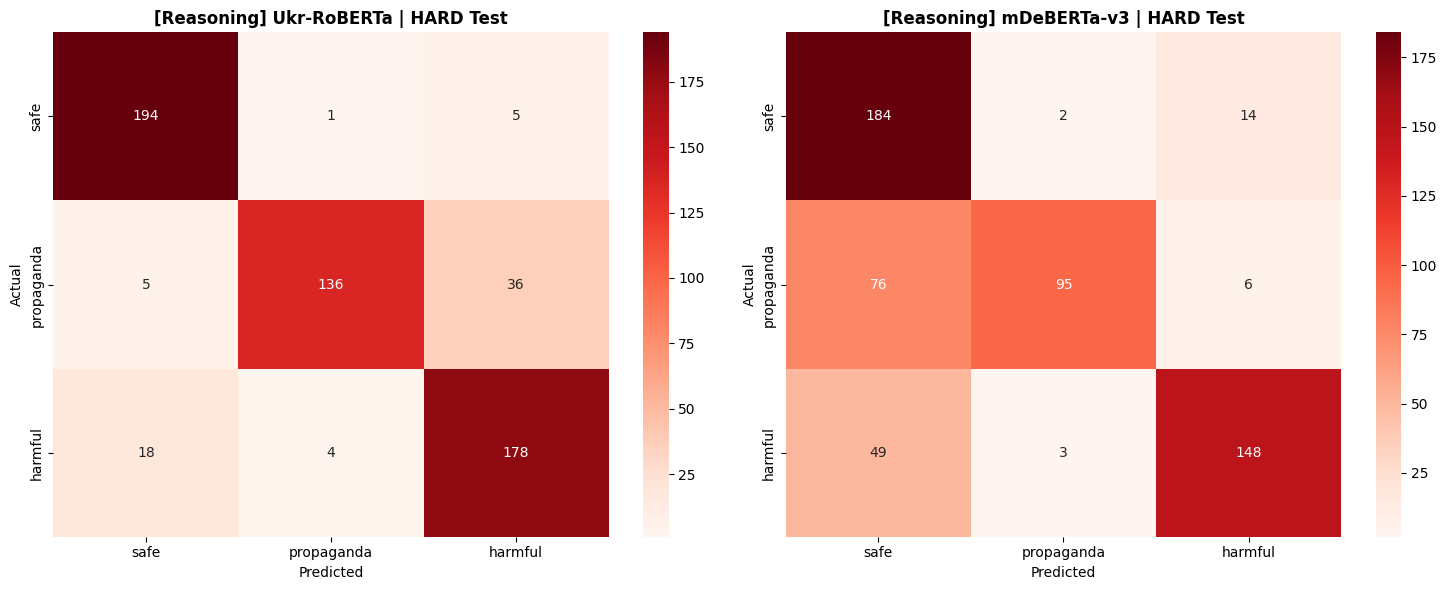

In [6]:
DATASETS_TO_TEST = [
    (TEST_FILE, "SIMPLE Test"),
    (HARD_TEST_FILE, "HARD Test"),
]

for path, name in DATASETS_TO_TEST:
    if os.path.exists(path):
        metrics, preds = run_benchmark_on_dataset(path, name)
        visualize_benchmark_results(metrics, preds, dataset_name=name, title_prefix="Reasoning")
    else:
        print(f"Dataset not found: {path}")